In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as torchdist
import torch.nn as nn

In [2]:
normal_dist = torchdist.Normal(loc=torch.tensor(0.), scale=torch.tensor(1.))

In [3]:
x = normal_dist.sample()

In [4]:
x

tensor(0.4063)

In [5]:
x = normal_dist.sample([100])

In [6]:
x

tensor([ 1.6774,  0.1234, -0.9912,  0.8905, -0.0122, -0.2393,  0.0310, -0.8617,
        -0.0675,  0.2600,  2.5545, -0.9863, -1.3105,  1.5854, -1.5111,  0.1622,
         0.8510,  0.5085, -1.5999,  0.1563,  1.6149,  2.2838,  0.2451, -0.6598,
         0.7310,  0.4014,  0.6186, -0.6048, -0.5232, -3.1592,  0.1353,  1.3936,
        -1.4316,  0.6467, -0.8830,  0.8399, -0.1304, -1.9118,  2.2981, -1.2245,
         0.0082, -0.1333,  0.2701,  1.1446, -1.9061, -0.2110, -0.7822, -0.8235,
         0.1951, -1.3258,  0.1363, -0.9456, -0.3342, -1.4718, -0.8263, -0.6666,
         0.0183,  1.5397,  1.9987,  0.1263, -0.2642,  0.8645, -0.2346, -0.3788,
         1.1588,  1.0861, -0.7055,  0.3127,  0.2434,  0.9194, -1.1752, -0.3657,
        -0.1713, -0.3522, -0.8703, -0.6205, -0.9794,  1.6203,  1.5940,  0.7790,
         0.9093,  0.2838, -1.5926, -0.9124, -0.9167,  0.1538,  0.9462, -0.7947,
        -0.7261,  0.9435,  1.8771, -0.7844, -0.5561, -1.6134,  0.3184, -1.4624,
        -0.0561,  0.7969,  0.1454,  0.94

(array([ 1.,  0.,  8., 12., 19., 25., 12., 12.,  7.,  4.]),
 array([-3.1592069 , -2.587833  , -2.0164587 , -1.4450848 , -0.87371075,
        -0.3023367 ,  0.26903734,  0.84041137,  1.4117854 ,  1.9831594 ,
         2.5545335 ], dtype=float32),
 <a list of 10 Patch objects>)

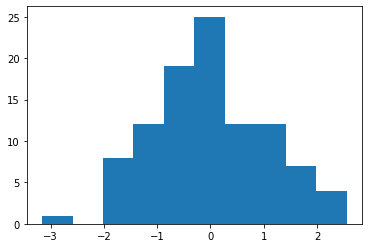

In [7]:
plt.hist(x.detach().numpy())

In [8]:
def toy_poly():
    x = 5 * torch.rand(100, 1)
    linear_op = -3 - 4*x + x**2
    y = torchdist.Normal(linear_op, 1).sample()
    return x, y

x_train, y_train = toy_poly()

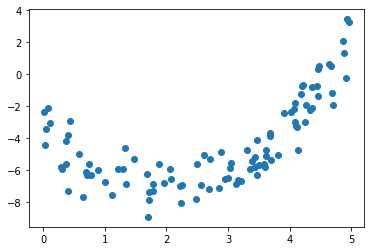

In [9]:
plt.plot(x_train.numpy(), y_train.numpy(), 'o')

## model

In [10]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        
    def forward(self, w, x):
        """
        w: shape of (3,)
        x: shape of (batch,)
        """
        #         phi_x = torch.tensor([])
        y = w[0] + w[1]*x + w[2]*x**2
        return y

In [11]:
class VImodel(nn.Module):
    """
    q(w; eta)
    """
    def __init__(self):
        super(VImodel, self).__init__()
        self.eta_mu = nn.Parameter(torch.tensor([0., 0., 0.]))
        self.eta_log_sigma = nn.Parameter(torch.tensor([0., 0., 0.]))
    
    def dist(self):
        eta_sigma = torch.exp(self.eta_log_sigma)
        q_w = torchdist.Normal(self.eta_mu, eta_sigma)
        
        return q_w
    '''
    def rsample(self):
        eta_sigma = torch.exp(self.eta_log_sigma)
        q_w = torchdist.Normal(self.eta_mu, eta_sigma)
        
        # shape of w: (3,)
        w = q_w.rsample()
        
        return w
    '''

In [12]:
def kl_divergence(vmodel, model, x, y):
    q_w = vmodel.dist()
    w_sample = q_w.rsample()    
    
    output = model(w_sample, x)    
    
    # p(y|x,w) = N(f(x; w), 1)
    p_y_xw = torchdist.Normal(output, torch.ones_like(output))
    # p(w) = N(0, 10)
    p_w = torchdist.Normal(torch.tensor([0., 0., 0.]), torch.tensor([10., 10., 10.]))
    
    # log(p(w, x, y)) = log(p(w)) + 1/n * sigma(log(p(y|x,w)))
    # val_log_joint_prob = p_w.log_prob(w_sample).sum() + p_y_xw.log_prob(y).mean()
    val_log_joint_prob = p_w.log_prob(w_sample).sum() + p_y_xw.log_prob(y).sum()
    
    val_log_q_w = q_w.log_prob(w_sample).sum()
    
    return val_log_q_w - val_log_joint_prob

In [25]:
vimodel = VImodel()
model = LinearNet()
optimizer = torch.optim.SGD(params=vimodel.parameters(), lr=1e-4)

In [26]:
for i in range(10000):
    optimizer.zero_grad()
    loss = kl_divergence(vimodel, model, x_train, y_train)
    loss.backward()
    optimizer.step()
    
    if (i+1) % 500 == 0 or (i==0):
        mu = vimodel.eta_mu.detach().numpy()
        sigma = torch.exp(vimodel.eta_log_sigma.detach()).numpy()
        print('loss: %f mu: %s sigma: %s' % (loss.detach().numpy(), str(mu), str(sigma)))

loss: 7410.587402 mu: [-0.11472235 -0.3671161  -1.3746064 ] sigma: [0.88104063 1.4720646  0.2835545 ]
loss: 227.094376 mu: [-3.4117908 -3.6606874  1.0593758] sigma: [0.33737305 0.08521175 0.0291636 ]
loss: 214.765579 mu: [-3.4714441 -3.8375568  1.0088277] sigma: [0.23361993 0.06739791 0.01954787]
loss: 206.256485 mu: [-3.4237854 -3.8548126  1.0481541] sigma: [0.19583374 0.05809425 0.01580062]
loss: 189.038986 mu: [-3.3965683 -3.8799932  1.0411365] sigma: [0.17246889 0.05366513 0.01389741]
loss: 268.155579 mu: [-3.3695724 -3.887896   1.0651734] sigma: [0.16302271 0.04982423 0.01279021]
loss: 168.008713 mu: [-3.3643274 -3.9135516  1.045206 ] sigma: [0.15023619 0.04680781 0.01186986]
loss: 180.547974 mu: [-3.3593822  -3.9449773   0.94493395] sigma: [0.1424612  0.04479468 0.01161086]
loss: 181.986801 mu: [-3.3562214 -3.9334843  1.0584545] sigma: [0.13734509 0.04235882 0.0109703 ]
loss: 177.640549 mu: [-3.3502862 -3.941318   1.0203962] sigma: [0.13217112 0.04005216 0.01063151]
loss: 172.632

In [27]:
vimodel.eta_mu

Parameter containing:
tensor([-3.3355, -3.9499,  1.0184], requires_grad=True)

In [24]:
torch.exp(vimodel.eta_log_sigma)

tensor([0.1034, 0.0347, 0.0087], grad_fn=<ExpBackward>)

In [17]:
q = torchdist.Normal(torch.tensor([0., 10.]), torch.tensor([1., 1.]))
w = q.sample()

In [18]:
w.size()

torch.Size([2])

In [19]:
plt.hist(w[:,1].numpy())

IndexError: too many indices for tensor of dimension 1

In [ ]:
def log_joint_prob(w0, w1, w2, x, y):
    prior_w0 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    prior_w1 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    prior_w2 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    
    linear = w0 + w1*x + w2*x**2
    likelihood = torchdist.Normal(linear, torch.ones_like(linear))
    
    return (
        prior_w0.log_prob(w0) +
        prior_w1.log_prob(w1) +
        prior_w2.log_prob(w2) +
        likelihood.log_prob(y).mean()
    )

In [ ]:
w0 = torch.nn.Parameter(torch.tensor(1.))
w1 = torch.nn.Parameter(torch.tensor(1.))
w2 = torch.nn.Parameter(torch.tensor(1.))

optimizer = torch.optim.Adam(params=[w0, w1, w2], lr=1e-3)

for i in range(30000):
    optimizer.zero_grad()
    log_joint_prob_value = log_joint_prob(w0, w1, w2, x_train, y_train)
    loss_value = - log_joint_prob_value
    loss_value.backward()
    optimizer.step()
    
    if (i+1) % 1000 == 0 or (i==0):
        print(loss_value.detach().numpy())

In [ ]:
print(w0)
print(w1)
print(w2)